# Radar Report of Maparadar e Federal Road Police Databases

In [1]:
import pandas as pd, folium, psycopg2, seaborn as sns, matplotlib as plt
from folium.plugins import FastMarkerCluster
from folium.plugins import Fullscreen
from folium.plugins import MiniMap

In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

# Summary
1. Quantity of Radars by Speed and Radar Type
1. Distribution of Radars by Speed and Type
1. Radar Map of Entire Brazil Maparadar Data
1. Radar Map of Entire Brazil Federal Road Police Data
1. Add Federal Road Police and Maparadar Data to Layers, Grouped by Speed and Type of Radar

This work presents the vizualization of Maparadar website and official Federal Road Police data, both available online.

Maparadar is a brazilian website for cooperative report of any type of radars troughout the country. The database can be downloaded in csv format file for free. Users commonly add the data to custom maps on navigation systems to acknowkledge the radar locations.

The Federal Road Police is responsible for patroling the federal roads of each state and the Federal District in Brazil. The data provided by the Federal Road Police is the only official available for the citizen until the moment of this article.

## Conection Configuration

In [3]:
conn = psycopg2.connect("host=10.3.40.10 dbname=db_testes_diversos user=i3geoconsulta password=i3geoconsulta")

## 1. Quantity of Radars by Speed and Radar Type

In [4]:
sql1 = """select maparadar.id_radar, maparadar.tipo_radar, maparadar.velocidade, maparadar.latitude, maparadar.longitude
from adv.tb_maparadar_brasil as maparadar
WHERE ST_Within(maparadar.geometry, (SELECT edterritorios_geometry
FROM spat.ed_territorios_paises AS spat_country
WHERE spat_country.edterritorios_codigo=1076));"""

df_mapa_radar = pd.read_sql_query(sql1, con=conn)
df_mapa_radar.head()

id_radar  tipo_radar  velocidade   latitude  longitude
0         1  radar fixo          30 -19.945982 -44.058251
1         2  radar fixo          30 -20.497509 -54.629503
2         3  radar fixo          30 -20.496151 -54.646202
3         4  radar fixo          30 -19.908390 -44.091283
4         5  radar fixo          30 -20.437418 -54.594010

In [5]:
df_mapa_radar.tipo_radar.unique()

array(['radar fixo', 'radar movel', 'semaforo com camera',
       'semaforo com radar', 'policia rodoviaria', 'pedagio', 'lombada'],
      dtype=object)

In [6]:
df_mapa_radar.velocidade.unique()

array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120,   0], dtype=int64)

In [7]:
df_mapa_radar.shape

(35456, 5)

In [8]:
df_gp_tp = df_mapa_radar.groupby("tipo_radar").agg("id_radar").count().reset_index()
df_gp_tp = df_gp_tp.sort_values(by="id_radar",ascending=False)

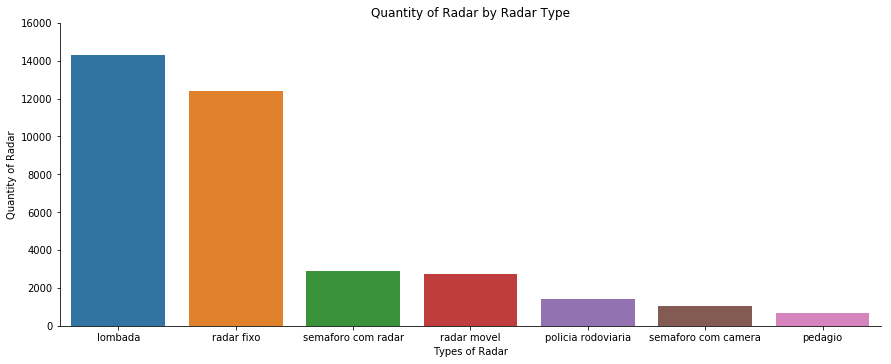

In [9]:
viz1 = sns.catplot(kind="bar", 
                   x="tipo_radar",
                   y="id_radar",
                   aspect=2.5,
                   height=5,
                   data=df_gp_tp)
viz1.ax.set_title("Quantity of Radar by Radar Type")
viz1.set_axis_labels("Types of Radar","Quantity of Radar")
viz1.set(ylim=(0,16000))
viz1.savefig("./viz/figures/adv-radares-brasil/viz1.svg")

The Figure 01 presents the data of Maparadar website grouped by radar type. The sequence of x-axis presents the type of brazilian radar types, in english, they are equivalent to: speed bump, stationary radar, traffic light radar, moving radar, road police, traffic light camera and toll booth, respectively. The specific quantity of each type is described by table 01 below:

In [10]:
df_gp_tp

tipo_radar  id_radar
0              lombada     14293
3           radar fixo     12391
6   semaforo com radar      2890
4          radar movel      2730
2   policia rodoviaria      1429
5  semaforo com camera      1057
1              pedagio       666

## 2. Distribution of Radars by Speed and Type

### 2.1 Distribution of Radars by Speed

In [11]:
df_gp_sp = df_mapa_radar.groupby("velocidade").agg("id_radar").count().reset_index()

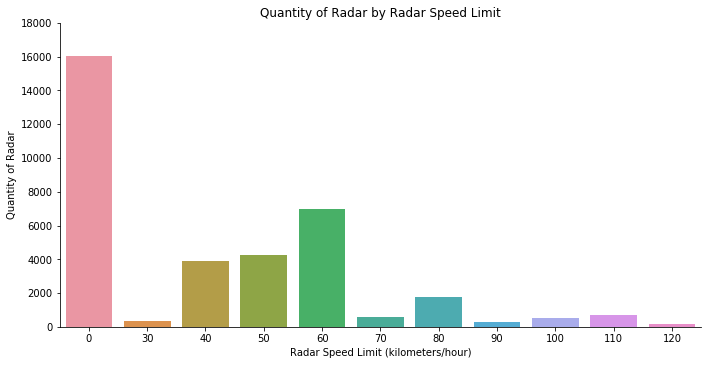

In [12]:
viz2 = sns.catplot(kind="bar", 
                   x="velocidade",
                   y="id_radar",
                   aspect=2.0,
                   height=5,
                   data=df_gp_sp)
viz2.ax.set_title("Quantity of Radar by Radar Speed Limit")
viz2.set_axis_labels("Radar Speed Limit (kilometers/hour)","Quantity of Radar")
viz2.set(ylim=(0,18000))
viz2.savefig("./viz/figures/adv-radares-brasil/viz2.svg")

Figure 02 depicts the quantity of radars by speed limit. It is noteworthy that the maximum value of 120 is the highest road speed allowed in Brazil, and all values are presented in kilometers/hour, the official speed unit measure of the country.

Despite the higher value is the zero speed, it must be removed by the final analysis because there is no anotation of the meaning of the value itself, might be a radar spoted, but not rated with any speed limit yet.

### 2.2 Distribution of Radars by Type

In [13]:
df_gp_sp_tp = df_mapa_radar.groupby(["velocidade","tipo_radar"]).agg("id_radar").count().reset_index()
speed_zero = df_gp_sp_tp["velocidade"]==0
df_gp_sp_tp_without_speed_zero = df_gp_sp_tp[~speed_zero]
df_gp_sp_tp_without_speed_zero = df_gp_sp_tp_without_speed_zero.sort_values(by="id_radar",ascending=False)

In [14]:
viz3 = sns.catplot(kind="bar", 
                   x="velocidade",
                   y="id_radar",
                   hue="tipo_radar",
                   aspect=2.0,
                   height=5,
                   data=df_gp_sp_tp_without_speed_zero)
viz3.ax.set_title("Quantity of Radar Type by Radar Speed Limit")
viz3.set_axis_labels("Radar Speed Limit","Quantity of Radar")
viz3.set(ylim=(0,5000))
viz3.savefig("./viz/figures/adv-radares-brasil/viz3.svg")

Following the criteria of interpreting the zero speed value in subchapter 2.1, the types of radar for each speed is generated without the aforementioned value, as the figure 03 presents. 

The data for zero speed is reported separately in figure 04, to generate insights for its possible meaning.

In [15]:
speed_zero = df_gp_sp_tp["velocidade"]==0
df_gp_sp_tp_with_speed_zero = df_gp_sp_tp[speed_zero]

In [16]:
viz4 = sns.catplot(kind="bar", 
                   x="velocidade",
                   y="id_radar",
                   hue="tipo_radar",
                   aspect=1.5,
                   height=4,
                   data=df_gp_sp_tp_with_speed_zero)
viz4.ax.set_title("Quantity of Radar Type by Radar Speed Limit")
viz4.set_axis_labels("Radar Speed Limit","Quantity of Radar")
viz4.set(ylim=(0,5000))
viz4.savefig("./viz/figures/adv-radares-brasil/viz4.svg")

## 3. Radar Map of Entire Brazil Maparadar Data

In [17]:
# Create a Map instance
mapa_radar = folium.Map(location=[-20.29, -44.64],
    zoom_start=2, control_scale=True)

minimap = MiniMap()
mapa_radar.add_child(minimap)

Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(mapa_radar)

callback = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "orange"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""                             
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
mapa_radar.add_child(FastMarkerCluster(df_mapa_radar[['latitude', 'longitude']].values.tolist(), callback=callback))
 
mapa_radar

## 4. Plot com dados agrupados

## 4.1 Por Velocidade (Em Cores)

In [18]:
df_gp_sp

velocidade  id_radar
0            0     16016
1           30       337
2           40      3905
3           50      4260
4           60      6951
5           70       592
6           80      1771
7           90       259
8          100       504
9          110       694
10         120       167

In [19]:
sp_120 = df_mapa_radar["velocidade"]==120
df_gp_sp_120 = df_mapa_radar[sp_120]
sp_110 = df_mapa_radar["velocidade"]==110
df_gp_sp_110 = df_mapa_radar[sp_110]
sp_100 = df_mapa_radar["velocidade"]==100
df_gp_sp_100 = df_mapa_radar[sp_100]
sp_90 = df_mapa_radar["velocidade"]==90
df_gp_sp_90 = df_mapa_radar[sp_90]
sp_80 = df_mapa_radar["velocidade"]==80
df_gp_sp_80 = df_mapa_radar[sp_80]
sp_70 = df_mapa_radar["velocidade"]==70
df_gp_sp_70 = df_mapa_radar[sp_70]
sp_60 = df_mapa_radar["velocidade"]==60
df_gp_sp_60 = df_mapa_radar[sp_60]
sp_50 = df_mapa_radar["velocidade"]==50
df_gp_sp_50 = df_mapa_radar[sp_50]
sp_40 = df_mapa_radar["velocidade"]==40
df_gp_sp_40 = df_mapa_radar[sp_40]
sp_30 = df_mapa_radar["velocidade"]==30
df_gp_sp_30 = df_mapa_radar[sp_30]

In [20]:
# Create a Map instance
radarmap_speed_groups = folium.Map(location=[-20.29, -44.64],
    zoom_start=2, control_scale=True)

minimap = MiniMap()
radarmap_speed_groups.add_child(minimap)

Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(radarmap_speed_groups)



callback_120 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "purple"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""                  
callback_110 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "gray"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""                 
callback_100 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "green"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""              
callback_90 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "blue"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
""" 
callback_80 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "red"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
""" 
callback_70 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "pink"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
""" 
callback_60 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "white"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
""" 
callback_50 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "brown"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
""" 
callback_40 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "dark blue"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""
callback_30 = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "camera", markerColor: "dark green"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
#120
plot_speed_radar_120 = FastMarkerCluster(df_gp_sp_120[['latitude', 'longitude']].values.tolist(), callback=callback_120)
radarmap_speed_groups.add_child(plot_speed_radar_120)

#110
plot_speed_radar_110 = FastMarkerCluster(df_gp_sp_110[['latitude', 'longitude']].values.tolist(), callback=callback_110)
radarmap_speed_groups.add_child(plot_speed_radar_110)

#90
plot_speed_radar_90 = FastMarkerCluster(df_gp_sp_90[['latitude', 'longitude']].values.tolist(), callback=callback_90)
radarmap_speed_groups.add_child(plot_speed_radar_90)

#80
plot_speed_radar_80 = FastMarkerCluster(df_gp_sp_80[['latitude', 'longitude']].values.tolist(), callback=callback_80)
radarmap_speed_groups.add_child(plot_speed_radar_80)

#70
plot_speed_radar_70 = FastMarkerCluster(df_gp_sp_70[['latitude', 'longitude']].values.tolist(), callback=callback_70)
radarmap_speed_groups.add_child(plot_speed_radar_70)

#60
plot_speed_radar_60 = FastMarkerCluster(df_gp_sp_60[['latitude', 'longitude']].values.tolist(), callback=callback_60)
radarmap_speed_groups.add_child(plot_speed_radar_60)

#50
plot_speed_radar_50 = FastMarkerCluster(df_gp_sp_50[['latitude', 'longitude']].values.tolist(), callback=callback_50)
radarmap_speed_groups.add_child(plot_speed_radar_50)

#40
plot_speed_radar_40 = FastMarkerCluster(df_gp_sp_40[['latitude', 'longitude']].values.tolist(), callback=callback_40)
radarmap_speed_groups.add_child(plot_speed_radar_40)

#30
plot_speed_radar_30 = FastMarkerCluster(df_gp_sp_30[['latitude', 'longitude']].values.tolist(), callback=callback_30)
radarmap_speed_groups.add_child(plot_speed_radar_30)

radarmap_speed_groups

## 4.2 Por Tipo de Radar

In [21]:
df_mapa_radar.groupby(by="tipo_radar").agg("id_radar").count().reset_index()

tipo_radar  id_radar
0              lombada     14293
1              pedagio       666
2   policia rodoviaria      1429
3           radar fixo     12391
4          radar movel      2730
5  semaforo com camera      1057
6   semaforo com radar      2890

In [22]:
radar_speed_bump = df_mapa_radar[df_mapa_radar["tipo_radar"]=="lombada"]
radar_toll_booth = df_mapa_radar[df_mapa_radar["tipo_radar"]=="pedagio"]
radar_road_police = df_mapa_radar[df_mapa_radar["tipo_radar"]=="policia rodoviaria"]
radar_stationary_radar = df_mapa_radar[df_mapa_radar["tipo_radar"]=="radar fixo"]
radar_moving_radar = df_mapa_radar[df_mapa_radar["tipo_radar"]=="radar movel"]
radar_traffic_light_camera = df_mapa_radar[df_mapa_radar["tipo_radar"]=="semaforo com camera"]
radar_traffic_light_radar = df_mapa_radar[df_mapa_radar["tipo_radar"]=="semaforo com radar"]

In [23]:
#prefix="fa" to retrieve icons from fontawesome.io
def add_map_marker(geo_lat, geo_long, msg, color, group):
    return folium.Marker(
    location=[geo_lat,geo_long],
    popup=msg,
    icon=folium.Icon(color=color, icon='camera', prefix="fa"),
).add_to(group)

def generate_speed_bump(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='green'
    gp_rd_sb = folium.plugins.FeatureGroupSubGroup(mcg, 'Speed Bump (Lombada)')
    radarmap_radar_type_groups.add_child(gp_rd_sb)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_sb)

def generate_toll_booth(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='gray'
    gp_rd_tb = folium.plugins.FeatureGroupSubGroup(mcg, 'Toll Booth (Pedágio)')
    radarmap_radar_type_groups.add_child(gp_rd_tb)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_tb)
    
def generate_road_police(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='darkblue'
    gp_rd_rp = folium.plugins.FeatureGroupSubGroup(mcg, 'Federal Road Police (Polícia Rodoviária Federal)')
    radarmap_radar_type_groups.add_child(gp_rd_rp)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_rp)

def generate_stationary_radar(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='purple'
    gp_rd_sr = folium.plugins.FeatureGroupSubGroup(mcg, 'Stationary Radar (Radar Fixo)')
    radarmap_radar_type_groups.add_child(gp_rd_sr)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_sr)
    
def generate_moving_radar(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='beige'
    gp_rd_mr = folium.plugins.FeatureGroupSubGroup(mcg, 'Moving Radar (Radar Móvel)')
    radarmap_radar_type_groups.add_child(gp_rd_mr)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_mr)
    
def generate_traffic_light_camera(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='darkred'
    gp_rd_tlc = folium.plugins.FeatureGroupSubGroup(mcg, 'Traffic Light Camera (Semáforo com Câmera)')
    radarmap_radar_type_groups.add_child(gp_rd_tlc)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_tlc)
    
def generate_traffic_light_radar(radar_data):
    geo_lat = radar_data.latitude.values
    geo_long = radar_data.longitude.values
    msg=radar_data.velocidade.values
    color='orange'
    gp_rd_tlr = folium.plugins.FeatureGroupSubGroup(mcg, 'Traffic Light Radar (Semáforo com Radar)')
    radarmap_radar_type_groups.add_child(gp_rd_tlr)
    for i in range(radar_data.shape[0]):
        add_map_marker(geo_lat[i],geo_long[i],msg[i],color,gp_rd_tlr)
        

radarmap_radar_type_groups = folium.Map(location=[-20.29, -44.64],
    zoom_start=1, control_scale=True)

minimap = MiniMap()
radarmap_radar_type_groups.add_child(minimap)

Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(radarmap_radar_type_groups)

mcg = folium.plugins.MarkerCluster(control=False)
radarmap_radar_type_groups.add_child(mcg)

generate_speed_bump(radar_speed_bump)
generate_toll_booth(radar_toll_booth)
generate_road_police(radar_road_police)
generate_stationary_radar(radar_stationary_radar)
generate_moving_radar(radar_moving_radar)
generate_traffic_light_camera(radar_traffic_light_camera)
generate_traffic_light_radar(radar_traffic_light_radar)

folium.LayerControl(collapsed=False).add_to(radarmap_radar_type_groups)

radarmap_radar_type_groups.save("map-maparadar-radar-types-brazil.html")

[Click to view Brazil Radar Map by types of Radar](./map-maparadar-radar-types-brazil.html "Brazil Radar Type Map")

# 5. Future Works

    * Compare speed limit of radar with roads speed limit